# Loading data

In [162]:
import pandas as pd

artificial_train = pd.read_csv('data/artificial_train.data', sep=' ', header=None).dropna(axis=1)
artificial_train_labels = pd.read_csv('data/artificial_train.labels', sep=' ', header=None).dropna(axis=1)
artificial_train_labels = (artificial_train_labels[0].values+1)/2
artificial_test = pd.read_csv('data/artificial_valid.data', sep=' ', header=None).dropna(axis=1)

In [163]:
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(artificial_train, artificial_train_labels, test_size=0.2, random_state=42)

## Preprocessing - scaling

In [164]:
# scale data
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_valid = scaler.transform(X_valid)
artificial_test = scaler.transform(artificial_test)

# Feature selection

## Logistic regression with L1 loss

In [165]:
import tqdm
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

list_of_regularisation_values = [0.03, 0.06, 0.1, 0.2, 0.3, 0.6]
list_of_accuracies_valid = []
list_of_accuracies_train = []
list_of_numbers_of_features = []
for regularisation_value in tqdm.tqdm(list_of_regularisation_values):
    lr = LogisticRegression(C=regularisation_value, random_state=1, penalty='l1', solver='liblinear')
    lr.fit(X_train, y_train)
    y_train_pred = lr.predict(X_train)
    y_valid_pred = lr.predict(X_valid)
    list_of_accuracies_valid.append(accuracy_score(y_valid, y_valid_pred))
    list_of_accuracies_train.append(accuracy_score(y_train, y_train_pred))
    list_of_numbers_of_features.append(sum(lr.coef_[0] != 0))

100%|██████████| 6/6 [00:04<00:00,  1.34it/s]


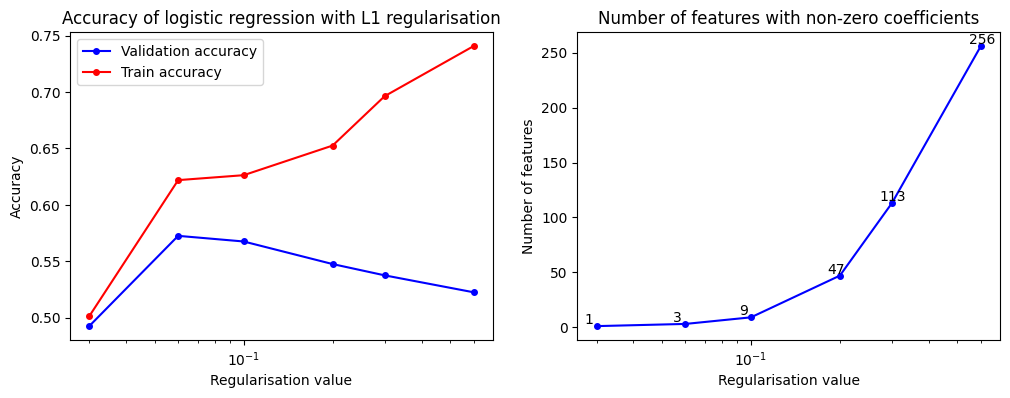

In [166]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

# plot accuracy wrt penalty value
ax[0].plot(list_of_regularisation_values, list_of_accuracies_valid, 'o-', label='Validation accuracy', color='blue', markersize=4)
ax[0].plot(list_of_regularisation_values, list_of_accuracies_train, 'o-', label='Train accuracy', color='red', markersize=4)
ax[0].set_xscale('log')
ax[0].set_title('Accuracy of logistic regression with L1 regularisation')
ax[0].set_xlabel('Regularisation value')
ax[0].set_ylabel('Accuracy')
ax[0].legend()

# plot number of features wrt penalty value
ax[1].plot(list_of_regularisation_values, list_of_numbers_of_features, 'o-', color='blue', markersize=4)
# add number to each dot
for i, txt in enumerate(list_of_numbers_of_features):
    ax[1].annotate(txt, (list_of_regularisation_values[i]/1.1, list_of_numbers_of_features[i]+2))
ax[1].set_xscale('log')
# ax[1].set_yscale('log')
ax[1].set_title('Number of features with non-zero coefficients')
ax[1].set_xlabel('Regularisation value')
ax[1].set_ylabel('Number of features')
plt.show()

## Random Forest

Accuracy of random forest on train set: 0.998


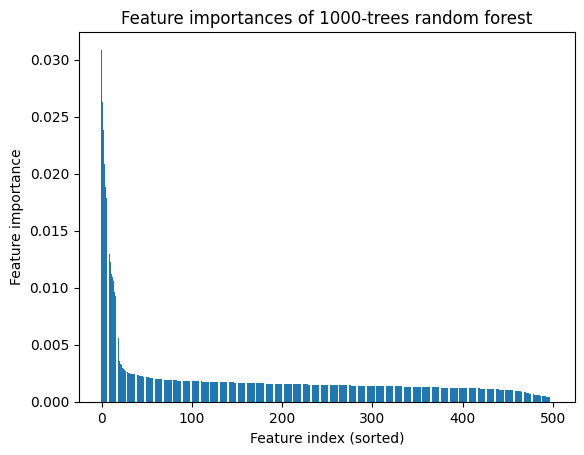

In [167]:
# import random forest
from sklearn.ensemble import RandomForestClassifier

# train random forest
N = 1000
rf = RandomForestClassifier(n_estimators=N, max_depth=7, random_state=1)
rf.fit(X_train, y_train)
print('Accuracy of random forest on train set: {:.3f}'.format(rf.score(X_train, y_train)))
importances = rf.feature_importances_
from matplotlib import pyplot as plt
plt.bar(list(range(len(importances))), sorted(importances, reverse=True))
plt.title(f'Feature importances of {N}-trees random forest')
plt.xlabel('Feature index (sorted)')
plt.ylabel('Feature importance')
plt.show()

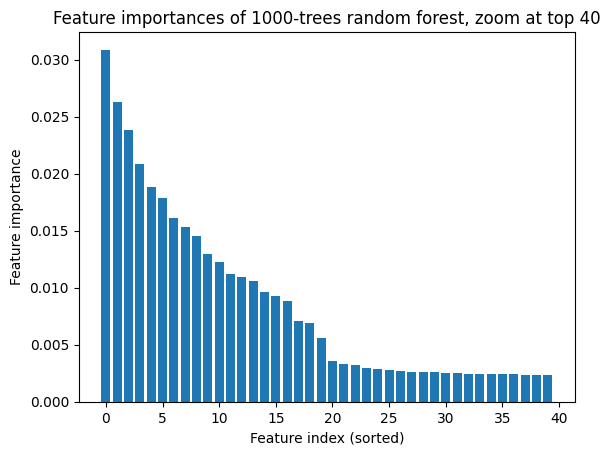

In [168]:
from matplotlib import pyplot as plt
plt.bar(list(range(len(importances)))[:40], sorted(importances, reverse=True)[:40])
plt.title(f'Feature importances of {N}-trees random forest, zoom at top 40')
plt.xlabel('Feature index (sorted)')
plt.ylabel('Feature importance')
plt.show()

### XGBoost based on top features only

In [175]:
from xgboost import XGBClassifier
from sklearn.metrics import balanced_accuracy_score

list_of_dicts = []
for i in tqdm.tqdm(range(1, 25)):
    list_of_features = list(importances.argsort()[-i:])
    rf = XGBClassifier(n_estimators=100, max_depth=20, random_state=1)
    rf.fit(X_train[:, list_of_features], y_train)
    y_train_pred = rf.predict(X_train[:, list_of_features])
    acc_train = balanced_accuracy_score(y_train, y_train_pred)
    y_valid_pred = rf.predict(X_valid[:, list_of_features])
    acc_valid = balanced_accuracy_score(y_valid, y_valid_pred)
    list_of_dicts.append({'Number of features': i,
                          'Train accuracy': acc_train,
                          'Validation accuracy': acc_valid,
                          'Project task Score' : acc_valid - 0.01 * max(0, 1/5 * i - 1)})

100%|██████████| 24/24 [00:08<00:00,  2.95it/s]


Best score was for 18 features and is 0.869


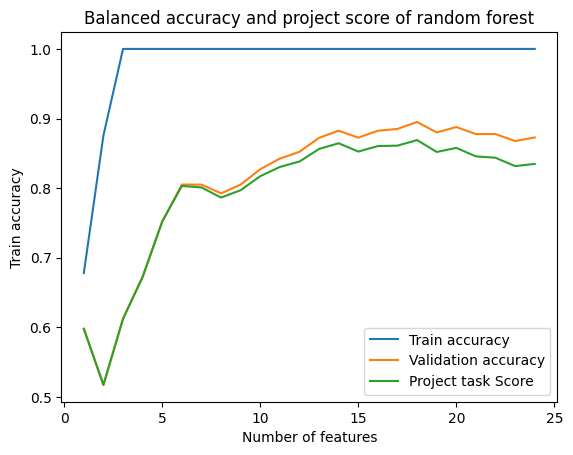

In [179]:
import seaborn as sns

df = pd.DataFrame(list_of_dicts)
print(f'Best score was for {df.iloc[df["Project task Score"].argmax()]["Number of features"]:.0f} features and is {df["Project task Score"].max():.3f}')

sns.lineplot(data=df, x='Number of features', y='Train accuracy', label='Train accuracy')
sns.lineplot(data=df, x='Number of features', y='Validation accuracy', label='Validation accuracy')
sns.lineplot(data=df, x='Number of features', y='Project task Score', label='Project task Score')
plt.title('Balanced accuracy and project score of random forest')
plt.show()